## Importy

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.src.layers import Bidirectional, LSTM, InputLayer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import Sequential, Input
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense


from utils.dataset_tools import DatasetTools

2025-10-12 19:36:12.243323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760290572.270562   21856 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760290572.281398   21856 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760290572.300461   21856 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760290572.300484   21856 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760290572.300487   21856 computation_placer.cc:177] computation placer alr

In [2]:
import gc
tf.keras.backend.clear_session()
gc.collect()

0

In [3]:
DATASET_PATH = '../dataset/fixed_augmented_dataset.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,sample_id,frame,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,landmark_21_x,landmark_21_y,landmark_21_z
0,0,0,Y,0.004203,0.000651,0.008161,-0.048246,0.005667,0.004781,-0.071473,...,-0.012839,0.031399,-0.181194,-0.032711,0.023335,-0.226115,-0.038200,0.025997,-0.283913,-0.038001
1,0,1,Y,-0.005988,-0.065978,0.008947,-0.033615,-0.096414,-0.025618,-0.079886,...,0.006703,0.011817,-0.283714,-0.021039,0.014646,-0.290970,-0.008102,-0.000139,-0.334014,-0.005190
2,0,2,Y,-0.000792,-0.093575,0.006636,-0.049848,-0.120680,-0.019714,-0.094480,...,-0.030904,0.011683,-0.311241,-0.034277,0.006597,-0.359876,-0.031719,0.002172,-0.388159,-0.011762
3,0,3,Y,-0.031170,-0.135088,-0.002417,-0.044940,-0.165431,-0.024812,-0.059180,...,0.000000,-0.001518,-0.348757,-0.035873,-0.001939,-0.344533,-0.040972,0.010580,-0.397630,-0.034706
4,0,4,Y,-0.017386,-0.127723,-0.018105,-0.029293,-0.149245,-0.021225,-0.083916,...,-0.017180,-0.006046,-0.302549,-0.033766,0.001081,-0.344521,-0.036471,0.013814,-0.386191,-0.018853


In [4]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# podział na sekwencje
sequences, labels = DatasetTools.divide_into_sequences(df)

# normalizacja punktów względem nadgarstka
# sequences = np.array([DatasetTools.normalize_wrist(seq) for seq in sequences])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(labels)  # 'A'...'Z' itd. -> 0...35

# One-hot encoding (36 klas)
y_cat = tf.keras.utils.to_categorical(y, num_classes=len(encoder.classes_))

# Konwersja typów
X = sequences.astype(np.float32)
print(X.shape, y_cat.shape)


(7749, 30, 63) (7749, 36)


In [5]:
from sklearn.model_selection import train_test_split

# najpierw train+val vs test (np. 70% : 30%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y
)

# następnie train vs val (np. 80% : 20% z trainval)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=np.argmax(y_trainval, axis=1)
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (4339, 30, 63) (4339, 36)
Val: (1085, 30, 63) (1085, 36)
Test: (2325, 30, 63) (2325, 36)


## Architektura modelu

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout

def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(shape=input_shape),
        Bidirectional(LSTM(16)),  # dwukierunkowy LSTM z 16 jednostkami
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Parametry dla PJM
input_shape = (30, 63)   # 30 klatek, 21 punktów * 3 współrzędne
num_classes = 36         # np. 36 liter alfabetu PJM

model = create_bilstm_model(input_shape, num_classes)
model.summary()


I0000 00:00:1760290650.701321   21856 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 172 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1760290650.719571   21856 cuda_executor.cc:479] failed to allocate 172.81MiB (181207040 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 32)             │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,692 (57.39 KB)

 Trainable params: 14,692 (57.39 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping],
    verbose=1       # opcjonalnie, pokazuje postęp
)


Epoch 1/100


I0000 00:00:1760290658.778654   21937 cuda_dnn.cc:529] Loaded cuDNN version 90300


136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0736 - loss: 3.5036 - val_accuracy: 0.1594 - val_loss: 2.8957
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2354 - loss: 2.4938 - val_accuracy: 0.4276 - val_loss: 1.9017
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4415 - loss: 1.7471 - val_accuracy: 0.5217 - val_loss: 1.5076
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5462 - loss: 1.3897 - val_accuracy: 0.6083 - val_loss: 1.1786
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6421 - loss: 1.0955 - val_accuracy: 0.6359 - val_loss: 1.0335
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6743 - loss: 0.9922 - val_accuracy: 0.6700 - val_loss: 0.9517
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6975 - loss: 0.8838 - val_accuracy: 0.7235 - val_loss: 0.8351
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7217 - loss: 0.8082 - val_accuracy:

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 0.2896
Test accuracy: 0.9161


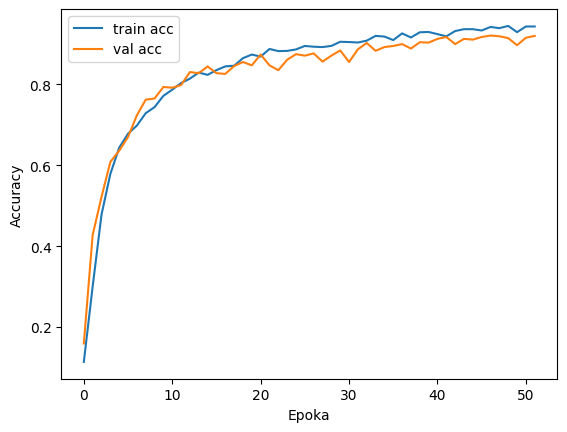

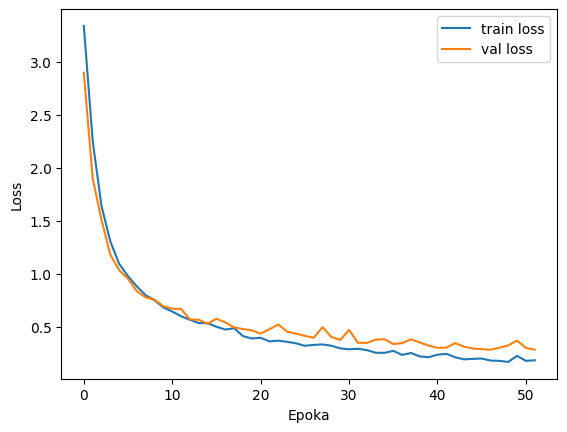

In [9]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
import os
from datetime import datetime

# Ustal dzisiejszą datę
today_str = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Ścieżka zapisu modeli
save_dir = f"../model/{today_str}"
os.makedirs(save_dir, exist_ok=True)

# Ścieżki plików
bilstm_path = os.path.join(save_dir, "bilstm_model.keras")
labels_path = os.path.join(save_dir, "labels.txt")

# Zapis modelu
model.save(bilstm_path)

with open(f'../model/{today_str}/labels.txt', 'w+') as f:
    for label in encoder.classes_:
        f.write(label + '\n')

print(f"Modele i etykiety zapisano w folderze: {save_dir}")


Modele i etykiety zapisano w folderze: ../model/2025-10-12-19:41:21


In [11]:
import gc

del model
del X_train, X_val, X_test
del y_train, y_val, y_test
gc.collect()


4816